# Импорт библиотек

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Загрузка данных

In [2]:
transformations = transforms.Compose([
  transforms.ToTensor()
])

batch_size = 64

train_dataset = MNIST(
    root="./",
    train=True,
    transform=transformations,
    download=True
)

test_dataset = MNIST(
    root="./",
    train=False,
    transform=transformations,
    download=True
)

## Задание 1. Загрузите данные с помощью  ```DataLoader```.

In [9]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=1,
    drop_last=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    num_workers=1,
    drop_last=True
)

# Автоэнкодер

## Задание 2. Используя архитектуру энкодера и декодерора, указанную в уроке, допишите класс ```SimpleAutoEncoder```.  

In [10]:
class SimpleAutoEncoder(nn.Module):
  def __init__(self, feature_size=2):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, 3, 1, 1),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(32, 64, 3, 2, 1),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(64, 64, 3, 1, 1),
        nn.LeakyReLU(inplace=True)
    )

    self.encoder_fc = nn.Linear(14*14*64, feature_size)
    self.decoder_fc = nn.Linear(feature_size, 14*14*64)

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 64, 3, 1, 1),
        nn.LeakyReLU(inplace=True),
        nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
        nn.LeakyReLU(inplace=True),
        nn.ConvTranspose2d(32, 1, 3, 1, 1),
        nn.Sigmoid()
    )

  def encode(self, x):
    x = self.encoder(x)
    x = torch.flatten(x, 1)
    x = self.encoder_fc(x)
    return x
  
  def decode(self, x):
    x = self.decoder_fc(x)
    x = x.view(-1, 64, 14, 14)
    x = self.decoder(x)
    return x

  def forward(self, x):
    z = self.encode(x)
    x_pred = self.decode(z)
    return x_pred

## Обучение модели

In [11]:
feature_size = 2
lr = 0.0005
nrof_epochs = 30
loss_fn_name = "rmse"
device = "cuda"

In [12]:
model = SimpleAutoEncoder(feature_size)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

loss_fn = {
    "mse": nn.MSELoss(),
    "rmse": nn.MSELoss(),
    "cross-entropy": nn.CrossEntropyLoss()
}[loss_fn_name]

min_loss = 10e6

In [8]:
!pip3 install torchsummary

In [13]:
from torchsummary import summary


summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         LeakyReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         LeakyReLU-4           [-1, 64, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          36,928
         LeakyReLU-6           [-1, 64, 14, 14]               0
            Linear-7                    [-1, 2]          25,090
            Linear-8                [-1, 12544]          37,632
   ConvTranspose2d-9           [-1, 64, 14, 14]          36,928
        LeakyReLU-10           [-1, 64, 14, 14]               0
  ConvTranspose2d-11           [-1, 32, 28, 28]          18,464
        LeakyReLU-12           [-1, 32, 28, 28]               0
  ConvTranspose2d-13            [-1, 1, 28, 28]             289
          Sigmoid-14            [-1, 1,

In [14]:
model.train()
for epoch in range(nrof_epochs):
  loss = 0.
  for i_batch, (x, _) in enumerate(train_loader):
    optimizer.zero_grad()

    x = x.to(device)
    x_pred = model(x)
      
    loss_batch = loss_fn(x_pred, x)
    if loss_fn_name == "rmse":
        loss_batch = torch.sqrt(loss_batch)
    loss_batch.backward()
    optimizer.step()

    loss += loss_batch
    
  loss = loss / (i_batch + 1)
  print(f"Epoch {epoch+1}/{nrof_epochs} | Loss {loss.item()}")

  if loss < min_loss:
      min_loss = loss
      torch.save(model.state_dict(), "./model.pt")

Epoch 1/30 | Loss 0.23509570956230164
Epoch 2/30 | Loss 0.2162991613149643
Epoch 3/30 | Loss 0.21147719025611877
Epoch 4/30 | Loss 0.20868012309074402
Epoch 5/30 | Loss 0.20650707185268402
Epoch 6/30 | Loss 0.20502454042434692
Epoch 7/30 | Loss 0.2036912441253662
Epoch 8/30 | Loss 0.20263750851154327
Epoch 9/30 | Loss 0.20185545086860657
Epoch 10/30 | Loss 0.201188862323761
Epoch 11/30 | Loss 0.20061223208904266
Epoch 12/30 | Loss 0.2000696212053299
Epoch 13/30 | Loss 0.19952382147312164
Epoch 14/30 | Loss 0.19915682077407837
Epoch 15/30 | Loss 0.19870038330554962
Epoch 16/30 | Loss 0.19832414388656616
Epoch 17/30 | Loss 0.19793373346328735
Epoch 18/30 | Loss 0.1975996196269989
Epoch 19/30 | Loss 0.19733582437038422
Epoch 20/30 | Loss 0.19701750576496124
Epoch 21/30 | Loss 0.19668027758598328
Epoch 22/30 | Loss 0.19637379050254822
Epoch 23/30 | Loss 0.1962038278579712
Epoch 24/30 | Loss 0.19590190052986145
Epoch 25/30 | Loss 0.19572177529335022
Epoch 26/30 | Loss 0.19538474082946777
Ep

## Валидация модели

In [15]:
model.eval()
loss = 0.
for i_batch, (x, _) in enumerate(test_loader):
  x = x.to(device)
  x_pred = model(x)
    
  loss_batch = loss_fn(x_pred, x)
  if loss_fn_name == "rmse":
    loss_batch = torch.sqrt(loss_batch)
  loss += loss_batch

loss = loss / (i_batch + 1)
print(f"Test set lost: {loss.item()}")

Test set lost: 0.19760529696941376


In [16]:
def rescale(x):
  x = x - np.min(x, (1, 2, 3)).reshape(-1, 1, 1, 1)
  x = x / np.max(x, (1, 2, 3)).reshape(-1, 1, 1, 1)
  return (x*255).astype(np.uint8)


def torch_to_numpy(x):
  x = x.detach().cpu().numpy()
  x = x.transpose(0, 2, 3, 1)
  x = rescale(x)
  return x
  

def make_samples_grid(x, x_pred=None, grid_shape=6*6):
  x = torch_to_numpy(x)
  if x_pred is not None:
    x_pred = torch_to_numpy(x_pred)
  
  n = 2 if x_pred is not None else 1

  H, W = x.shape[1:3]
  m = int(np.sqrt(grid_shape))
  grid = np.zeros((H*m, W*m), dtype=np.uint8)

  i = 0
  for row in range(m):
    for col in range(m):
      sample = [x, x_pred][i%n]
      grid[H*row:H*(row+1), W*col:W*(col+1)] = sample[int(i//n)][..., 0]
      i += 1
  return grid

In [18]:
# Реконструкция нескольких изображений из тестового датасета
indices = np.arange(len(test_dataset))
np.random.shuffle(indices)

x = []
y = []
for index in indices:
  image, label = test_dataset[index]
  x.append(image)
  y.append(label)

x = torch.stack(x)
x = x.to(device)
x_pred = model(x)

grid = make_samples_grid(x, x_pred)
plt.imshow(grid, cmap="gray")
plt.show()

RuntimeError: CUDA out of memory. Tried to allocate 958.00 MiB (GPU 0; 8.00 GiB total capacity; 6.66 GiB already allocated; 0 bytes free; 7.09 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

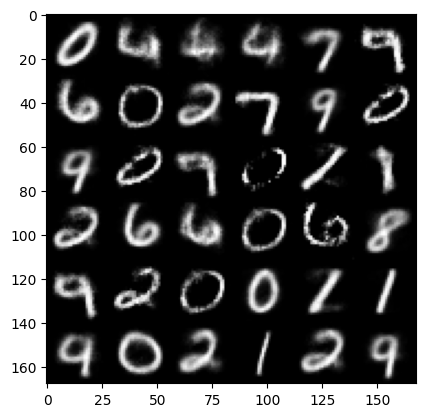

In [29]:
# Генерация сэмплов из шума
random = np.sqrt(10)*torch.randn((36, 2))
random = random.to(device)
random_samples = model.decode(random)

grid = make_samples_grid(random_samples)
plt.imshow(grid, cmap="gray")
plt.show()